**Profit Sensitive Default Classification with XGBoost**

**Author: Or Cohen**

In this notebook three different approaches to the optimization of a credit risk model will be tested and benchmarked. The focus is on improving the business sense and financial preformance of the classification model and hence the prelimanry development stage (data validation, feature engineering and selection, missing value imputation, etc.) will be succint. For a full explanation of the methodology please read the [blog post](https://cohen-or.github.io/posts/pscr2.html)

### Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [1]:
!pip install -q opendatasets

In [2]:
# IF YOU DON'T HAVE A KAGGLE ACCOUNT - TRY ENTERING "O" FOR BOTH username and password
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1/data"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: o
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1


In [5]:
%%capture
chunk_size = 10000
file_path = '/content/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip'
sampled_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    sampled_chunks.append(chunk.sample(n=1000, random_state=42))

df = pd.concat(sampled_chunks)

### Part 1: Parsing the data and preparing features + binary target

In [ ]:
# create a shortlist of all features we will use
features = ['loan_amnt','emp_length','home_ownership','purpose','annual_inc','dti','fico','mths_since_earliest_cr_line','verification_status']

In [ ]:
# convert dates to datetime dtype
for col in ['issue_d', 'earliest_cr_line','last_pymnt_d','next_pymnt_d']:
    df[col] = pd.to_datetime(df[col])

# convert term to numeric dtype
df['term'] = df['term'].str.extract(r'(\d+)').astype(float)

# covert int rate to numeric dtype
df['int_rate'] = df.int_rate.str.replace('%','').astype(float).div(100)

# convert employment length to numeric dtype
df['emp_length'] = df.emp_length.replace({'< 1 year':'0'}).str.extract(r'(\d+)').astype(float)

# convert fico range to single score
df['fico'] = df[['fico_range_high','fico_range_low']].mean(axis=1)

# infer the length of time from ealiest credit line date to application date
mths_diff = lambda d1, d2: (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month)
df['mths_since_earliest_cr_line'] = mths_diff(df.issue_d, df.earliest_cr_line)


<ipython-input-5-c6fda54a534f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-5-c6fda54a534f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-5-c6fda54a534f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
<ipython-input-5-c6fda54a534f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_da

***inspecting and handling features data distributions***

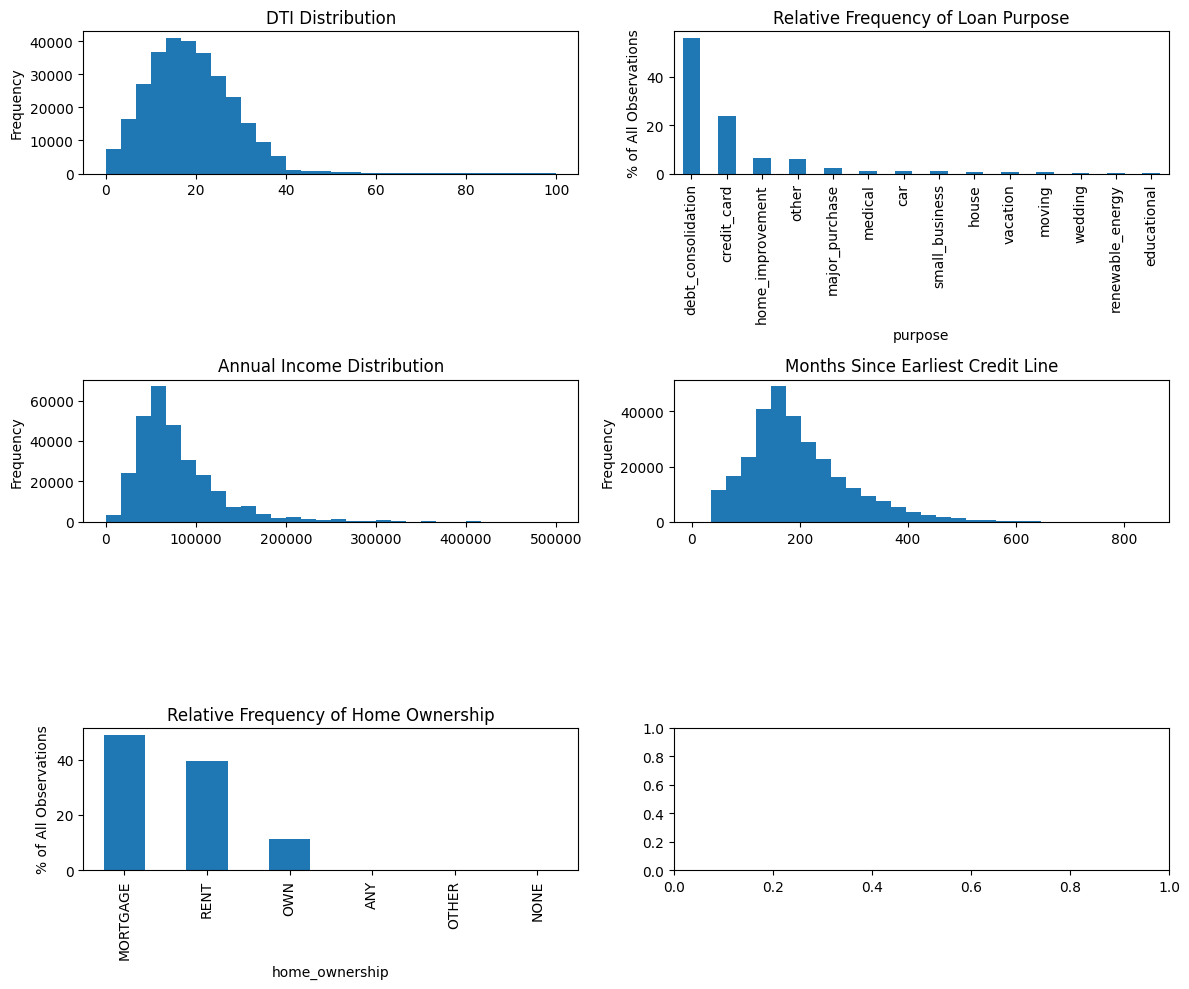

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# plot 1: dti
df.query('dti.between(0,100)').dti.plot(kind='hist', bins=30, ax=axes[0, 0], title='DTI Distribution')

# plot 2: purpose
df.purpose.value_counts(normalize=True).multiply(100).plot(kind='bar', ax=axes[0, 1], title='Relative Frequency of Loan Purpose')
axes[0, 1].set_ylabel('% of All Observations')

# plot 3: annual income
df.query('annual_inc < 500000').annual_inc.plot(kind='hist', bins=30, ax=axes[1, 0], title='Annual Income Distribution')

# plot 4: months since earliest credit line
df.mths_since_earliest_cr_line.plot(kind='hist', bins=30, ax=axes[1, 1], title='Months Since Earliest Credit Line')

# plot 5: homeo wnership
df.home_ownership.value_counts(normalize=True).multiply(100).plot(kind='bar', ax=axes[2, 0], title='Relative Frequency of Home Ownership')
axes[2, 0].set_ylabel('% of All Observations')

plt.tight_layout()
plt.show()


In [ ]:
# set upper limit of dti to 43%
# this value is consistent with standard hard cut off rules that most lenders use as first line of defense
df['dti'] = df.dti.clip(upper=43).div(100)

# consolidate marginal purposes
df['purpose'] = df.purpose.replace({val:'other' for val in df.purpose.unique() if val not in ['credit_card','debt_consolidation']})

# set upper limit for credit history to 50 years
df['mths_since_earliest_cr_line'] = df.mths_since_earliest_cr_line.clip(upper=600)

# set upper limit of annual income to 250K
df['annual_inc'] = df.annual_inc.clip(upper=250000)

# consolidate home ownership status
df['home_ownership'] = df.home_ownership.replace({'ANY': 'RENT','NONE':'RENT','OTHER':'RENT'})

**check and handle missing value**

In [ ]:
df[features].isna().mean().sort_values(ascending=False)

,0
emp_length,0.070485
dti,0.001031
mths_since_earliest_cr_line,0.000020
annual_inc,0.000003
loan_amnt,0.000000
home_ownership,0.000000
purpose,0.000000
fico,0.000000
verification_status,0.000000


In [ ]:
# fill missing values
df.fillna({'emp_length':0,
           'mths_since_earliest_cr_line':0,
           'annual_inc': df.annual_inc.median(),
           'dti':df.dti.median(),
           'fico':300},
          inplace=True)

In [ ]:
# one-hot encoding of categorical variables (remove first to prevent dummy variable trap)
categorical = ['home_ownership','purpose','verification_status']
dummies = pd.get_dummies(df[categorical], prefix_sep = ':', drop_first=True)
df = pd.concat([df, dummies], axis=1)
# update features list
features = list(set(features) - set(categorical)) + dummies.columns.tolist()

**creating a binary classification target**

In [ ]:
df.loan_status.value_counts(normalize=True)

,proportion
loan_status,
Fully Paid,0.512328
Current,0.351792
Charged Off,0.123655
Late (31-120 days),0.005812
In Grace Period,0.003587
Late (16-30 days),0.000942
Issued,0.000727
Does not meet the credit policy. Status:Fully Paid,0.000672
Does not meet the credit policy. Status:Charged Off,0.000297


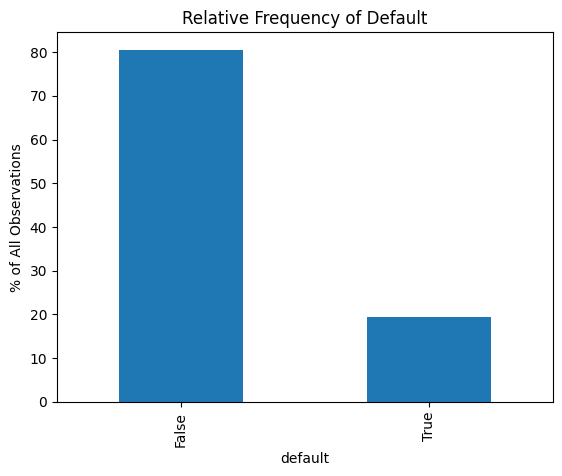

In [ ]:
# set the target and remove irrelevant observations
df['default'] = df.loan_status.replace({'Fully Paid':0,'Charged Off':1,'Default':1})
df.drop(df.query('default != 1 and default !=0').index, inplace=True)
df['default'] = df.default.astype(bool)

# plot the target distribution
df.default.value_counts(normalize=True).multiply(100).plot(kind='bar', title='Relative Frequency of Default')
plt.ylabel('% of All Observations')
plt.show()

In [ ]:
# display the training dataframe
df[features+['default']].sample(10)

,loan_amnt,fico,mths_since_earliest_cr_line,dti,annual_inc,emp_length,home_ownership:OWN,home_ownership:RENT,purpose:debt_consolidation,purpose:other,verification_status:Source Verified,verification_status:Verified,default
2900447,40000.0,727.0,152.0,0.3021,150000.0,6.0,True,False,True,False,False,True,False
771794,10000.0,687.0,63.0,0.3453,35000.0,2.0,False,True,True,False,False,False,True
1290376,20000.0,707.0,148.0,0.1897,87000.0,8.0,False,False,True,False,True,False,False
1332239,10500.0,747.0,169.0,0.0638,54000.0,10.0,False,False,False,False,True,False,False
2098178,20000.0,692.0,284.0,0.3617,86000.0,8.0,False,False,True,False,False,True,True
2367262,15000.0,687.0,249.0,0.2151,62000.0,0.0,False,False,True,False,False,False,False
160764,5500.0,797.0,247.0,0.2511,44100.0,10.0,False,False,False,False,False,False,False
2008703,14400.0,672.0,137.0,0.1695,48000.0,9.0,False,True,True,False,False,True,False
2660795,16000.0,717.0,304.0,0.2116,108000.0,2.0,False,False,True,False,False,False,False
556517,10000.0,692.0,150.0,0.0872,68000.0,7.0,False,False,False,False,False,False,False


### Part 2: Training and Testing Baseline Models

In this section we will train and test two baseline models: **Logistic** Regression and XGBoost

In [ ]:
# train test split
test_size = 0.2
np.random.seed(42)
test_idx = np.random.choice(df.index, size=int(test_size * len(df)), replace=False)
train_idx = np.setdiff1d(df.index, test_idx)

# separate features and target in both sets
X_train, y_train = df.loc[train_idx, features].values, df.loc[train_idx, 'default'].values
X_test, y_test = df.loc[test_idx, features].values, df.loc[test_idx, 'default'].values

# scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# train logistic regression model
lr_cls = LogisticRegression(random_state=42)
lr_cls.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# evaluating logistic regression
test_df = df.loc[test_idx]
test_df['lr_preds'] = lr_cls.predict_proba(X_test)[:,1]
print(classification_report(y_test, test_df.lr_preds.gt(0.5)))
roc_lr = roc_auc_score(y_test, test_df.lr_preds)
print(f'ROC score: {roc_lr:.2f}')

              precision    recall  f1-score   support

       False       0.81      1.00      0.89     30016
        True       0.43      0.00      0.01      7263

    accuracy                           0.80     37279
   macro avg       0.62      0.50      0.45     37279
weighted avg       0.73      0.80      0.72     37279

ROC score: 0.65


In [ ]:
# train XGboost model
xgb_cls = XGBClassifier(random_state=42)
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# evaluating xgboost
test_df['xgb_preds'] = xgb_cls.predict_proba(X_test)[:,1]
print(classification_report(y_test, test_df.xgb_preds.gt(0.5)))
roc_xgb = roc_auc_score(y_test, test_df.xgb_preds)
print(f'ROC score: {roc_xgb:.2f}')

              precision    recall  f1-score   support

       False       0.81      0.99      0.89     30016
        True       0.41      0.03      0.05      7263

    accuracy                           0.80     37279
   macro avg       0.61      0.51      0.47     37279
weighted avg       0.73      0.80      0.73     37279

ROC score: 0.65


In [ ]:
# train XGboost with scaled proportion
scale_ratio = round(len(df.loc[train_idx].query('~default')) / len(df.loc[train_idx].query('default')))
print(f'The scale ratio to be used is {scale_ratio:.2f}')
xgb_cls_scaled = XGBClassifier(random_state=42, scale_pos_weight=scale_ratio)
xgb_cls_scaled.fit(X_train, y_train)

The scale ratio to be used is 4.00


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# evaluating scaled xgboost
test_df['scaled_xgb_preds'] = xgb_cls_scaled.predict_proba(X_test)[:,1]
print(classification_report(y_test, test_df.scaled_xgb_preds.gt(0.5)))
roc_xgb_scaled = roc_auc_score(y_test, test_df.scaled_xgb_preds)
print(f'ROC score: {roc_xgb_scaled:.2f}')

              precision    recall  f1-score   support

       False       0.86      0.64      0.74     30016
        True       0.28      0.56      0.37      7263

    accuracy                           0.63     37279
   macro avg       0.57      0.60      0.55     37279
weighted avg       0.75      0.63      0.66     37279

ROC score: 0.65


**Midpoint summary:**

The base line models result in the out-of-sample test dataset:
1. Logistic regression was able to detect **0% of all defaults**.
2. XGBoost was able to detect **3% of all defaults** and **of its default predictions 41% were indeed defaults**.
3. XGBoost with a higher weight to the minority class (defaults) was able to detect **56% of all defaults** and **of its default predictions 28% were indeed defaults**. This came at the cost of lower recall on the majority class (only 64% of the good loans were predicted as good)

### Part 3: Deriving Profitability Scoring

In [ ]:
# inspect the average tenure of loans in each class based on the term
df['tenure'] = mths_diff(df.last_pymnt_d, df.issue_d)
pd.pivot_table(df, index='default', columns='term',values='tenure', aggfunc='mean', margins=True)

term,36.0,60.0,All
default,,,
False,22.403518,26.029112,23.184202
True,15.268600,18.777395,16.684333
All,21.304285,23.782354,21.927991


In [ ]:
avg_life = df.query('default').tenure.mean()

# outcome of correctly predicted good loan
df['installment'] = df.loan_amnt * (df.int_rate.div(12) * df.int_rate.div(12).add(1).pow(df.term)).div(df.int_rate.div(12).add(1).pow(df.term).sub(1))
df['exp_total_pymt'] = df.installment.mul(avg_life) + (df.loan_amnt * ((df.int_rate.div(12).add(1).pow(df.term) - df.int_rate.div(12).add(1).pow(avg_life)).div(df.int_rate.div(12).add(1).pow(df.term).sub(1))))
df.loc[~df.default,'pi_tn'] = df.exp_total_pymt.div(df.loan_amnt)

# outcome of incorrectly predicted good loan
df['recoveries_pv'] = df.recoveries.div(df.int_rate.add(1).pow(2)) # present value of recoveries assuming 2 years to recieve and the loan interest rate as rate of return
df.loc[df.default,'pi_fn'] =  df[['total_rec_prncp','total_rec_int','recoveries_pv','total_rec_late_fee']].sum(axis=1).div(df.loan_amnt)

df['pi'] = df[['pi_tn','pi_fn']].sum(axis=1)

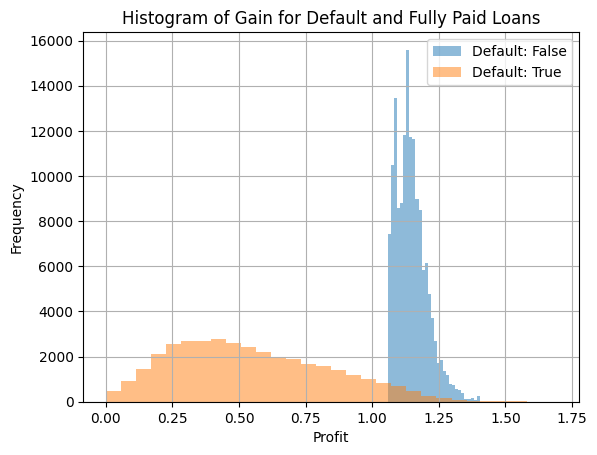

In [ ]:
for label in df['default'].unique():
    subset = df[df['default'] == label]
    plt.hist(subset['pi'], bins=30, alpha=0.5, label=f'Default: {label}')

plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Gain for Default and Fully Paid Loans')
plt.legend()
plt.grid(True)
plt.savefig('gain_hist.png')

In [ ]:
df['exp_reco'] = df.grade.map(
    df.query('default').assign(reco_rate = lambda x: x.recoveries_pv / (x.loan_amnt - x.total_rec_prncp))
    .groupby('grade').reco_rate.mean().to_dict()
    )
df['lgd'] = 1 - df.exp_reco

def expected_profit(df, p_default, required_approval_rate):
    # mask approved loans based on lowest PD
    approved_pd = p_default.lt(p_default.quantile(required_approval_rate)).reindex(df.index, fill_value=False)
    # mask approved loans based on greatest spread between interest rate and default premium
    default_premium = df.loc[test_idx,'lgd'] * p_default
    spread = df.int_rate - default_premium
    approved_spd = spread.gt(spread.quantile(required_approval_rate)).reindex(df.index, fill_value=False)
    exp_profits = {'PD approved': df.loc[approved_pd, 'pi'].mean() -1,
                   'PD rejected': df.loc[~approved_pd, 'pi'].mean() -1,
                   'Spread approved': df.loc[approved_spd, 'pi'].mean() -1,
                   'Spread rejected': df.loc[~approved_spd, 'pi'].mean() -1
                   }
    return exp_profits

tests = {'Logistic Regression': test_df.lr_preds,
         'XGboost': test_df.xgb_preds,
         'XGboost - Scaled Weights': test_df.scaled_xgb_preds}

avg_profit = pd.DataFrame(index=tests.keys(), columns=['PD approved','PD rejected','Spread approved','Spread rejected'])
for test in tests:
  avg_profit.loc[test] = expected_profit(df, tests[test], 0.8)
avg_profit.style.format("{:.2%}")

,PD approved,PD rejected,Spread approved,Spread rejected
Logistic Regression,4.18%,2.66%,4.75%,2.83%
XGboost,4.12%,2.67%,5.37%,2.80%
XGboost - Scaled Weights,4.19%,2.66%,5.61%,2.79%


### Part 4: Training and testing profit sensitive model

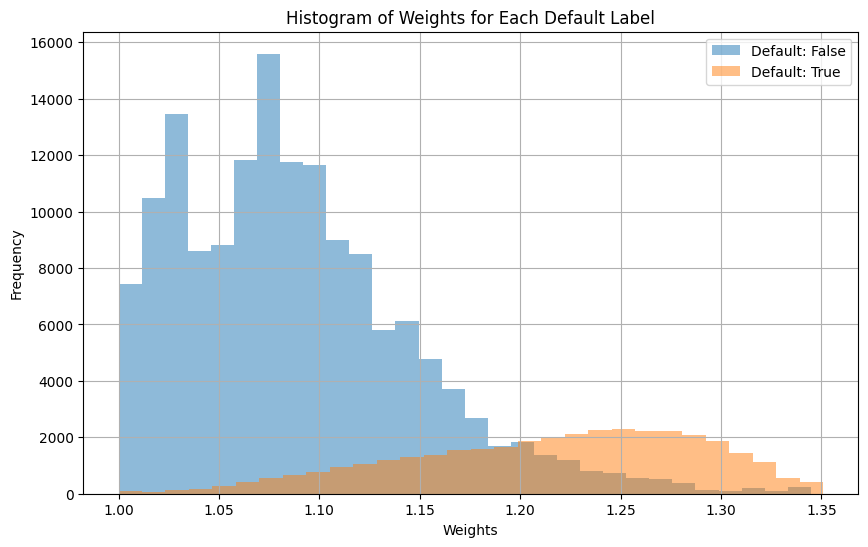

In [ ]:
# Define the weight of each observation based on its gain/loss profile
# Higher gains/losses in each class respectively will be assigned a higher weight
df['weights'] = df.pi.sub(1)
df['weights'] = np.where(df.default,
                         df.weights.mul(-1).add(df.query('~default').weights.max()).clip(lower=0).div(4),
                         df.weights.sub(df.query('~default').weights.min()))
df['weights'] += 1

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

for label in df['default'].unique():
    subset = df[df['default'] == label]
    plt.hist(subset['weights'], bins=30, alpha=0.5, label=f'Default: {label}')

plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.title('Histogram of Weights for Each Default Label')
plt.legend()
plt.grid(True)
plt.savefig('weights_hist.png')

In [ ]:
cs_xgb_cls = XGBClassifier(random_state=42, scale_pos_weight=2)
cs_xgb_cls.fit(X_train, y_train, sample_weight=df.loc[train_idx,'weights'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# evaluating cost sensitive XGboost
test_df['cs_xgb_preds'] = cs_xgb_cls.predict_proba(X_test)[:,1]
print(classification_report(y_test, test_df.cs_xgb_preds.gt(0.5)))
roc_lr = roc_auc_score(y_test, test_df.cs_xgb_preds)
print(f'ROC score: {roc_lr:.2f}')

              precision    recall  f1-score   support

       False       0.83      0.90      0.86     30016
        True       0.34      0.21      0.26      7263

    accuracy                           0.77     37279
   macro avg       0.58      0.56      0.56     37279
weighted avg       0.73      0.77      0.74     37279

ROC score: 0.65


In [ ]:
avg_profit.loc['XGboost - Cost Sensitive'] = expected_profit(df, test_df.cs_xgb_preds, 0.8)
avg_profit.style.format("{:.2%}")

,PD approved,PD rejected,Spread approved,Spread rejected
Logistic Regression,4.18%,2.66%,4.75%,2.83%
XGboost,4.12%,2.67%,5.37%,2.80%
XGboost - Scaled Weights,4.19%,2.66%,5.61%,2.79%
XGboost - Cost Sensitive,4.22%,2.65%,6.05%,2.77%
